# SMS Spam Detection

<br>
<i>This code has the goals to verifify if some sms message it's a spam or not</i>

# Installing the dataset

In [0]:
%%shell

if ! [ -d "./dataset" ]; then
  mkdir dataset
  echo "> Created the dataset directory"
fi

if ! [ -f "./dataset/SMSSpamCollection" ]; then
  rm -f ./dataset/smsspamcollection.zip
  wget -P ./dataset https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
  
  echo "> Downloaded the dataset"
  
  sudo apt-get install -y unzip
  unzip ./dataset/smsspamcollection.zip -d ./dataset
fi


# Importing the dataset

In [0]:
import pandas as pd

dataset = pd.read_csv('./dataset/SMSSpamCollection', sep="\t")
dataset.columns = ['spam', 'text']
dataset.spam = dataset.spam.map({'ham': 0, 'spam': 1})

print(f"Size of the dataset: {dataset.shape[0]}")

dataset.head(10)

Size of the dataset: 5571


,spam,text
0,0,Ok lar... Joking wif u oni...
1,1,Free entry in 2 a wkly comp to win FA Cup fina...
2,0,U dun say so early hor... U c already then say...
3,0,"Nah I don't think he goes to usf, he lives aro..."
4,1,FreeMsg Hey there darling it's been 3 week's n...
5,0,Even my brother is not like to speak with me. ...
6,0,As per your request 'Melle Melle (Oru Minnamin...
7,1,WINNER!! As a valued network customer you have...
8,1,Had your mobile 11 months or more? U R entitle...
9,0,I'm gonna be home soon and i don't want to tal...


## Wordcloud of the SPAM's

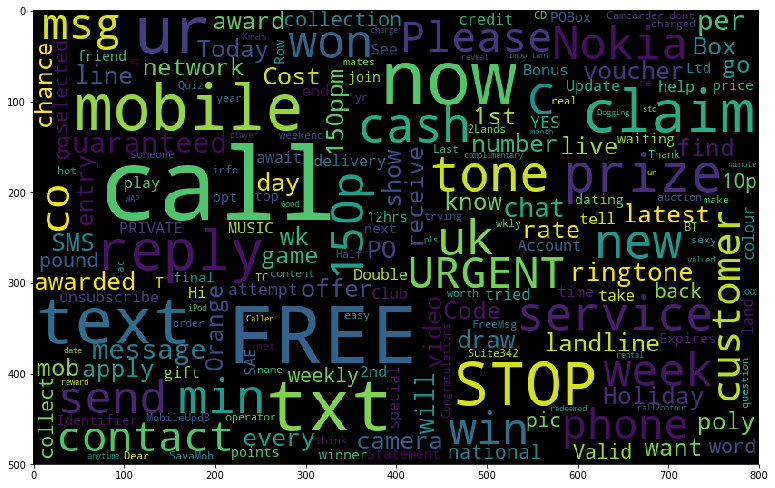

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = " ".join(list(dataset[dataset.spam == 1].text))

# Create a wordcloud image
word_cloud = WordCloud(width=800, height=500, background_color='#000', max_font_size=110, collocations=False).generate(all_words)

# Configure the plot
plt.figure(figsize=(13, 13))
plt.imshow(word_cloud)
plt.show()

## Printing the spam messages

In [0]:
spam_msgs = dataset.text[dataset.spam == 1]

for value in spam_msgs.sample(10).values:
  print(value + "\n")

Free 1st week entry 2 TEXTPOD 4 a chance 2 win 40GB iPod or £250 cash every wk. Txt VPOD to 81303 Ts&Cs www.textpod.net custcare 08712405020.

Reply to win £100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service

okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm

0A$NETWORKS allow companies to bill for SMS, so they are responsible for their "suppliers", just as a shop has to give a guarantee on what they sell. B. G.

+123 Congratulations - in this week's competition draw u have won the £1450 prize to claim just call 09050002311 b4280703. T&Cs/stop SMS 08718727868. Over 18 only 150ppm

You have 1 new message. Please call 08718738034.

Can U get 2 phone NOW? I wanna chat 2 set up meet Call me NOW on 09096102316 U can cum here 2moro Luv JANE xx Calls£1/minmoremobsEMSPOBox45PO139WA

Dont forget you can place as many FREE Requests with 1stchoice.

# Preprocessing

### Installing and import the dependecies

In [0]:
import re
import nltk
from nltk.tokenize import WhitespaceTokenizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### 1. Cleaning:
    Clear and get only the main part from the dataset
    Ex: remove the tags of the html.
    Ex: filter the texts in PDF and etc.

In [0]:
def clean(text):
    # Remove the HTML tags
    text = re.sub("<!--?.*?-->","",text)
    text = re.sub("<.*?>","",text)
    
    return text

### 2. Normalization:
    Remove the pontuation, tags, put everything in same case and etc.

In [0]:
def normalize(text):
    # Convert to lower case
    text = text.lower()
    
    # remove special characters and digits
    text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)
    
    text = text.replace('  ', ' ')
    
    return text

### 3. Tokenization:
    Split the text in words spliting by the whitespaces.

In [0]:
def tokenizer(text):    
    tokenizer = WhitespaceTokenizer()
    tokens = tokenizer.tokenize(text)
    
    return tokens

### 4. Stop Words:
    They are words witch don't get no one meaning, they are just used to complement the context,
    and to connect the terms.
    Ex: 'i', 'you', 'in', 'out', 'are', 'the'

In [0]:
from nltk.corpus import stopwords

# Remove the stop words, they are words witch don't give no one especific meaning
def remove_stopwords(tokens):
    stop_words = list(stopwords.words("english"))
    
    return [w for w in tokens if w not in stop_words]

### 5. Stemming:
    Takes of the variation of the words and remove the finally to combine than.
    Ex: 'change', 'changing', 'changes' => 'chang'


### 6. Lemmatization:
    Takes the variation of the same word and convert to the same one (Noun).
    Ex: 'is', 'were', 'was' => 'be'
    Ex: 'ones' => 'one'

    Part of Speech(PoS) (Verb):
    Ex: 'bored' => 'bore'
    Ex: 'stating' => 'start'

In [0]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Remove the pural
# Remove the verb conjugation
def stem(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in words]

# Remove the personality
def lem(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in words]

### 7. Tag filtering
    Filter the words according with the part of speech like a noun, verbs, adverbs and etc.

In [0]:
import nltk

# RB | RB | JJ | NN | NNP | JJ | JJS | IN | VB | VBZ | VBD | VBG

# IN = preposition/subordinating conjunction

# RB = adverb very, silently
# RBR = adverb, comparative better
# RBS = adverb, superlative best
# RP = particle give up

# IN = preposition/subordinating conjunction
# JJ = adjective ‘big’
# JJR = adjective, comparative ‘bigger’
# JJS = adjective, superlative ‘biggest’

# VB verb, base form take
# VBD verb, past tense took
# VBG verb, gerund/present participle taking
# VBN verb, past participle taken
# VBP verb, sing. present, non-3d take
# VBZ verb, 3rd person sing. present takes

# Filter using regular array
def filter_tokens(tokens):
    tags = [x[1] for x in nltk.pos_tag(list(tokens))]
    filters = ("RB", "RBR", "RBS", "RP", "JJ", "JJR", "JJS", "JJ", "VB")
    
    return [tokens[i] for i in range(len(tokens)) if tags[i] in filters]

### 8. Transform the numbers and currency
    In this case, we have an occurs of numbers, but the numbers can be variate and that variation don't give to us some new meaning. To resolve that problem, it's possible to substitute the word with has numbers to 'tagnumber'

In [0]:
def transform_numbers(tokens):
    return ["tagnumber" if bool(re.search(r'\d', w)) else w for w in tokens]

    Remove the currency check if contains that simbols ¥,$,€ and £ in word and update to "tagmoney"

In [0]:
def any_curr(s, curr="¥$€£"):
    return any(c in s for c in curr)

def transform_currency(tokens):
  return ["tagmoney" if any_curr(w) else w for w in tokens]

### 9. Transform e-mail

    The ideia here it's change the occurencies of the e-mails just to the name "tagemail"

In [0]:
def transform_email(tokens):
    return ["tagemail" if "@" in w else w for w in tokens]

### 10. Transform URL's
    Transform the URL's in "taglink"

In [0]:
def transform_link(tokens):
    return ["taglink" if any(re.findall('www?.(?:[-\w.]|(?:%[\da-fA-F]{2}))+', w)) else w for w in tokens]

### 11. Transform the fraud word
    After analyse the dataset it's possible see some words whitch are more used in spam, so we change it to "tagfraud"

In [0]:
def transform_fraud_word(tokens):
    words = ['win', 'gain', 'prize', 'free', 'guaranteed', 'unlimited', 'reply', 'congratulations', 'urgent', 'call', 'profit', 'claim', 'urgent', 'won', 'contact', 'cache', 'voucher']
    return ["tagfraud" if w in words else w for w in tokens]

# Normalizing and Cleaning the dataset

In [0]:
from IPython.core.display import HTML, display

# Normalizing the dataset
dataset["text"] = pd.Series([" ".join(
    # 5. Unify the words witch its most probably to be a spam
    transform_fraud_word(
        
      # 4. Extract the links behind
      transform_link(
          
          # 3. Extranct the emails
          transform_email(
              
              # 2. Check if contains numbers and change to "tagnumber"
              transform_numbers(
                  
                  # 1. Extract if has currency in the middle of the text
                  transform_currency(tokenizer(normalize(clean(txt))))
              )
          )
      )
    )
) for txt in dataset["text"].values])

display(HTML("<h2>> Normalized!<h2/>"))

# Bag of Words

    Now let's create our word dictinary, called too Bag of Words(BoW)

In [0]:
# Concatenate all texts
all_words = " ".join(list(dataset.text))

# Split in tokens
tokens = tokenizer(all_words)
print("> Tokenized!")

# Group by the words using Stem and Lemmantize techiniques
# tokens = stem(tokens)
tokens = lem(tokens)
print("> Merged the term to the root form!")

# Filter the words accourding with the Part of Speech
# tokens = filter_tokens(tokens)
# print("> Filtred by tags witch get more meaning!")

# Remove the stop of words
tokens = remove_stopwords(tokens)
print("> Removed the stop words!")

# Show the first 100 words 
print("\nColection [:100]:\n")

for i in range(10):
  print(tokens[(10 * i):(10 * i + 10)])

> Tokenized!
> Merged the term to the root form!
> Removed the stop words!

Colection [:100]:

['ok', 'lar', 'joking', 'wif', 'u', 'oni', 'tagfraud', 'entry', 'tagnumber', 'wkly']
['comp', 'tagfraud', 'fa', 'cup', 'final', 'tkts', 'tagnumber', 'may', 'tagnumber', 'text']
['fa', 'tagnumber', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['tagnumber', 'u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'life', 'around', 'though', 'freemsg', 'hey', 'darling']
['tagnumber', 'week', 'word', 'back', 'like', 'fun', 'still', 'tb', 'ok', 'xxx']
['std', 'chgs', 'send', 'tagnumber', 'tagnumber', 'rcv', 'even', 'brother', 'like', 'speak']
['treat', 'like', 'aid', 'patent', 'per', 'request', 'melle', 'melle', 'oru', 'minnaminunginte']
['nurungu', 'vettam', 'ha', 'set', 'callertune', 'caller', 'press', 'tagnumber', 'copy', 'friend']
['callertune', 'winner', 'valued', 'network', 'customer', 'selected', 'receivea', 'tagnumber', 'tagfraud',

### Get the frequency of the words

In [0]:
import nltk

# Get the frequency of the words
frequency = nltk.FreqDist(tokens)

# Create the bag of words dataframe
bag_of_words = pd.DataFrame({"words": list(frequency.keys()), "frequency": list(frequency.values())})

# Remove the most unique words
bag_of_words = bag_of_words[bag_of_words.frequency > 7]

# Order by the Frequency
bag_of_words.sort_values(by="frequency", ascending=False, inplace=True)
bag_of_words.reset_index(drop=True, inplace=True)

# Save the bag of words
bag_of_words.to_csv('./dataset/bag-of-words.csv', index=True)

print(f"Back of words size: {bag_of_words.shape[0]}")

print(bag_of_words.shape[0])
bag_of_words.head(5)

Back of words size: 1061
1061


,words,frequency
0,tagnumber,4465
1,tagfraud,1642
2,u,1274
3,get,402
4,ur,391


### Plot the frequency in Word Cloud

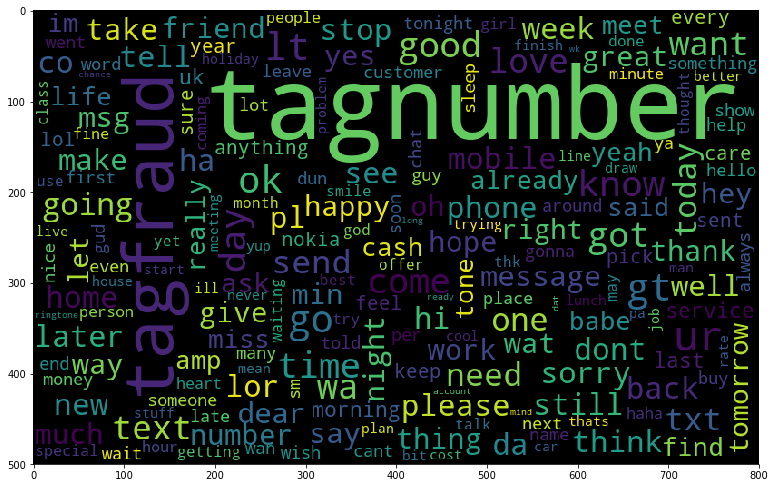

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a wordcloud image
word_cloud = WordCloud(width=800, height=500, background_color='#000', max_font_size=110, collocations=False).generate(" ".join(tokens))

# Configure the plot
plt.figure(figsize=(13, 13))
plt.imshow(word_cloud)
plt.show()

### Remove unnecessary variable

In [0]:
del word_cloud
del all_words
del tokens
del frequency
del bag_of_words

# TF-IDF

### Config

In [0]:
# Load the dictinary
bag_of_words = pd.read_csv('./dataset/bag-of-words.csv')
bag_of_words_array = bag_of_words.words.values

# Load the dataset
dataset = pd.read_csv('./dataset/SMSSpamCollection', sep="\t")
dataset.columns = ['spam', 'text']
dataset.spam = dataset.spam.map({'ham': 0, 'spam': 1})
inputs = dataset.text.values

### Implemetation

In [0]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Create a TF-IDF function
def vectorizer(txt, vocabulary=None):
    txt = list(txt)

    # Vectorize using the vocabulary and without the normalization
    tf = TfidfVectorizer(analyzer='word', vocabulary=vocabulary)
    txt_transformed = tf.fit(txt).transform(txt)

    
    return txt_transformed.toarray(), tf.get_feature_names()

In [0]:
tfidf, feature_names = vectorizer(inputs, bag_of_words_array)

# Show the TF-IDF
view = pd.DataFrame(tfidf, columns=feature_names)
view.head(10)

,tagnumber,tagfraud,u,get,ur,gt,lt,go,ok,day,know,come,like,good,time,got,wa,love,text,want,send,need,one,today,r,txt,going,home,c,stop,lor,sorry,see,still,take,n,mobile,back,da,dont,...,egg,pizza,space,fault,slept,bedroom,student,mark,library,sp,letter,future,awaiting,ar,inc,black,fat,finger,digital,fight,paying,lemme,woman,miracle,workin,nigeria,sign,daddy,medical,goto,registered,fixed,entitled,bak,anymore,swt,training,file,present,funny
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.416103,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.175704,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.177784,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212468,0.0,0.0,0.0,0.223140,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.231664,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.243828,0.0,0.0,0.00000,0.246633,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.555841,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.43417,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.33837,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,

### Remove unnecessary variable

In [0]:
del view

# Naive Bayes

### Config

In [0]:
from sklearn.model_selection import train_test_split

# Create the resources
X = tfidf
y = dataset.spam.values

# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, stratify = y)

### Model

In [0]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np

np.random.seed(42)

# Create a Multinomial bayes model from sklearn
model = MultinomialNB()

# Fit the model
model.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Score the model

In [0]:
from IPython.core.display import display, HTML

# Predict using text X
y_pred = model.predict(X_test)
# 
# Accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
result = "Accuracy: %.2f" % (accuracy*100) + "%"

# Show the result in HTML
display(HTML(f'<h2>{result}</h2>'))